In [29]:
import rasterio as rio
from matplotlib import pyplot as plt
import hvplot.pandas
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import holoviews as hv
import matplotlib.colors as mcolors

In [30]:
# Open the file and get a file "handle"
landsat = rio.open("./LST.tiff")
landsat

<open DatasetReader name='./LST.tiff' mode='r'>

In [31]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 7741,
 'height': 7861,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(30.0, 0.0, 395385.0,
        0.0, -30.0, 4582215.0)}

In [32]:
# read the data of band1
data = landsat.read(1)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
city_limits = gpd.read_file("/Users/tushimin/Desktop/week-4/data/City_Limits.geojson")

In [34]:
city_limits = city_limits.to_crs(landsat.crs.data['init'])

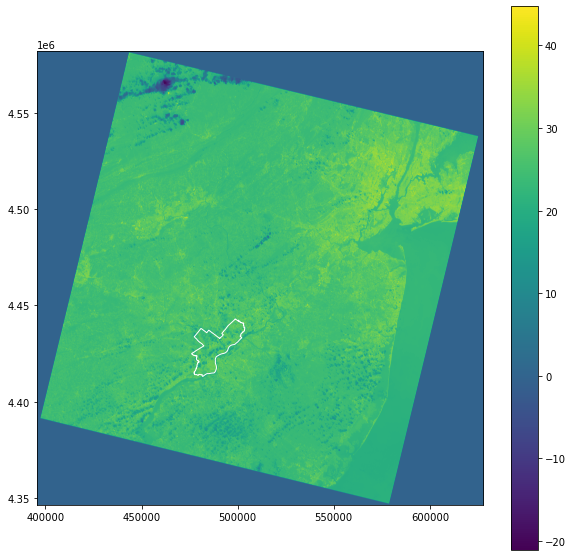

In [37]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img = ax.imshow(
    data,
    extent=[  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ],
)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar
plt.colorbar(img)


In [36]:
from rasterio.mask import mask

In [38]:
# trim to philly city limits
masked, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

masked, mask_transform = mask(
    dataset=landsat,
    shapes=city_limits.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

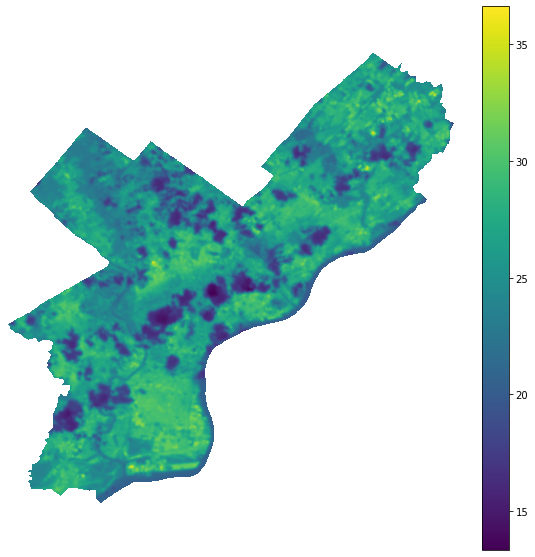

In [43]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first band
img = ax.imshow(masked[0], cmap="viridis", extent=landsat_extent)

# Add a colorbar and turn off axis lines
plt.colorbar(img)
ax.set_axis_off()

In [44]:
# save cropped raster data
out_meta = landsat.meta
out_meta.update(
    {"height": masked.shape[1], "width": masked.shape[2], "transform": mask_transform}
)
print(out_meta)

# write small image to local Geotiff file
with rio.open("cropped_landsat.tif", "w", **out_meta) as dst:
    dst.write(masked)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 924, 'height': 1001, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 476055.0,
       0.0, -30.0, 4443075.0)}


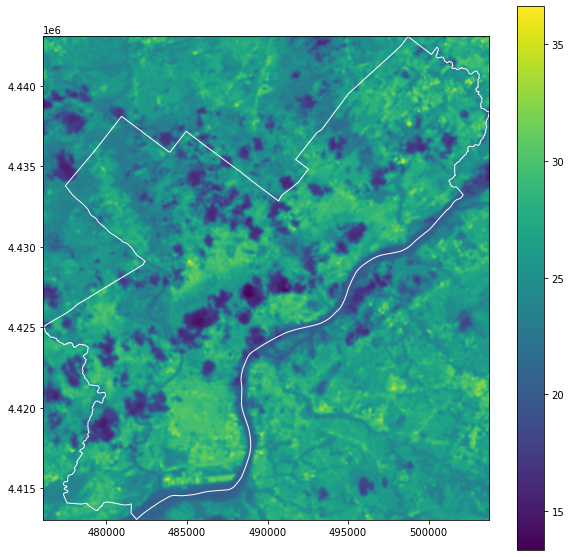

In [47]:
# check whether it goes well
landsat1 = rio.open("./cropped_landsat.tif")
data1 = landsat1.read(1)
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img1 = ax.imshow(
    data1,
    extent=[  # Set the extent of the images
        landsat1.bounds.left,
        landsat1.bounds.right,
        landsat1.bounds.bottom,
        landsat1.bounds.top,
    ],
)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar
plt.colorbar(img1)


In [53]:
landsat1

<open DatasetReader name='./cropped_landsat.tif' mode='r'>

In [49]:
parks = gpd.read_file('./parks.geojson')

In [51]:
# Conver to landsat CRS
parks = parks.to_crs(landsat.crs.data['init'])

In [52]:
parks.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

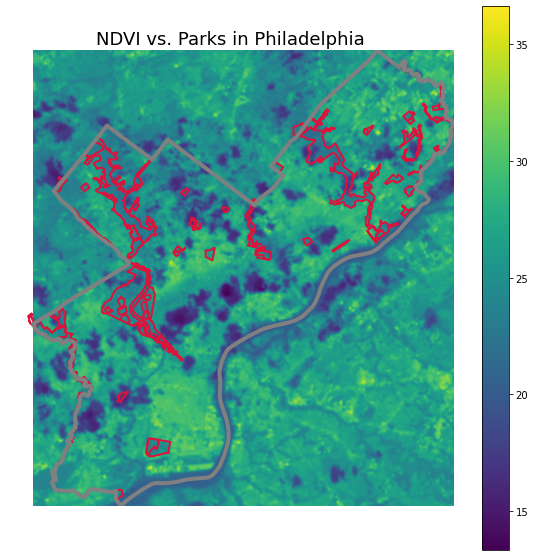

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot NDVI
img = ax.imshow(data1, extent=[  
        landsat1.bounds.left,
        landsat1.bounds.right,
        landsat1.bounds.bottom,
        landsat1.bounds.top,
    ],)

# NEW: add the parks
parks.plot(ax=ax, edgecolor='crimson', facecolor='none', linewidth=2)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI vs. Parks in Philadelphia", fontsize=18);

In [56]:
from rasterstats import zonal_stats

In [58]:
stats = zonal_stats(parks, data1, affine=landsat1.transform, stats=['mean', 'median'])

/Users/tushimin/opt/anaconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [59]:
stats

[{'mean': 23.03619851001876, 'median': 23.058727264404297},
 {'mean': 23.614231498699993, 'median': 24.02130699157715},
 {'mean': 22.33008729163767, 'median': 22.7097225189209},
 {'mean': 23.928786530091298, 'median': 24.00661849975586},
 {'mean': 22.17036219872664, 'median': 22.760841369628906},
 {'mean': 24.84999280563189, 'median': 24.624971389770508},
 {'mean': 26.50333548153148, 'median': 26.41179847717285},
 {'mean': 19.970722869038582, 'median': 19.877896308898926},
 {'mean': 17.672890895121807, 'median': 17.151811599731445},
 {'mean': 26.441636730375745, 'median': 26.502212524414062},
 {'mean': 23.711782271286538, 'median': 23.609764099121094},
 {'mean': 21.752605607024336, 'median': 21.272260665893555},
 {'mean': 26.191451693044126, 'median': 26.082578659057617},
 {'mean': 24.175159683933966, 'median': 24.05972385406494},
 {'mean': 26.360096922374908, 'median': 26.255050659179688},
 {'mean': 25.37658891820196, 'median': 25.253929138183594},
 {'mean': 24.460814535281077, 'media

In [60]:
len(parks)

63

In [61]:
len(stats)

63

In [62]:
parks['median_t'] = [s['median'] for s in stats] 

In [65]:
parks.head()

,OBJECTID,ASSET_NAME,SITE_NAME,CHILD_OF,ADDRESS,TYPE,USE_,DESCRIPTION,SQ_FEET,ACREAGE,ZIPCODE,ALLIAS,NOTES,TENANT,LABEL,DPP_ASSET_ID,Shape__Area,Shape__Length,geometry,median_t
0,7,Wissahickon Valley Park,Wissahickon Valley Park,Wissahickon Valley Park,None,LAND,REGIONAL_CONSERVATION_WATERSHED,NO_PROGRAM,9.078309e+07,2084.101326,19128,,MAP,SITE,Wissahickon Valley Park,1357,1.441162e+07,71462.556702,"MULTIPOLYGON (((484101.476 4431051.989, 484099...",23.058727
1,8,West Fairmount Park,West Fairmount Park,West Fairmount Park,,LAND,REGIONAL_CONSERVATION_WATERSHED,NO_PROGRAM,6.078159e+07,1395.358890,19131,,MAP,SITE,West Fairmount Park,1714,9.631203e+06,25967.819064,"MULTIPOLYGON (((482736.681 4428824.579, 482728...",24.021307
2,23,Pennypack Park,Pennypack Park,Pennypack Park,,LAND,REGIONAL_CONSERVATION_WATERSHED,NO_PROGRAM,6.023748e+07,1382.867808,19152,Verree Rd Interpretive Center,MAP,SITE,Pennypack Park,1651,9.566914e+06,41487.394790,"MULTIPOLYGON (((497133.192 4434667.950, 497123...",22.709723
3,24,East Fairmount Park,East Fairmount Park,East Fairmount Park,,LAND,REGIONAL_CONSERVATION_WATERSHED,NO_PROGRAM,2.871642e+07,659.240959,19121,,MAP,SITE,East Fairmount Park,1713,4.549582e+06,21499.126097,"POLYGON ((484539.743 4424162.545, 484620.184 4...",24.006618
4,25,Tacony Creek Park,Tacony Creek Park,Tacony Creek Park,,LAND,REGIONAL_CONSERVATION_WATERSHED,NO_PROGRAM,1.388049e+07,318.653500,19120,,MAP,SITE,Tacony Creek Park,1961,2.201840e+06,19978.610852,"MULTIPOLYGON (((491712.882 4429633.244, 491713...",22.760841


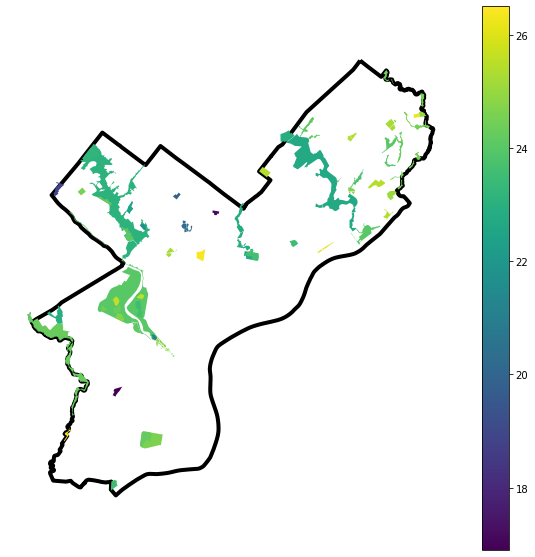

In [64]:
# Initialize
fig, ax = plt.subplots(figsize=(10,10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=4)

# Plot the median NDVI
parks.plot(column='median_t', legend=True, ax=ax, cmap='viridis')

# Format
ax.set_axis_off()